# ASTR 598 Astrostatistics
## HW4 - Classification of QSO and Stars
## Chris Suberlak, Hayden Smotherman, Winnie Wang

The objects in the matched data set are chosen based on Naive Bayes, KNN, and Decision Trees. Here we present the classification of stars and quasars using these threee methods, which are compared to the example presented in the text. In the following analysis, we had cut quasars at z=2, to avoid contamination of stellar locus. The reason for that is explained in the [Addendum](#addendum)

In [4]:
%matplotlib inline

import numpy as np
from astropy.table import Table
from astropy.table import hstack
import os 
import matplotlib.pyplot as plt 
from matplotlib import colors

from astroML.utils import split_samples
from astroML.utils import completeness_contamination
from astroML.classification import GMMBayes

from sklearn.metrics import roc_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

The necessary files to run this notebook can be found here:
https://drive.google.com/drive/folders/1r3o2I9iK6nrSDbbXTBX-YJM81BzIvAbh

They should be placed in the same working directory as this notebook.

Note that the file

`hlc_nsc_half_arcsec.npy`

is **not** needed for the classification, but is used in the first few cells to illustrate the location of stellar and QSO sample on the background of all HLC-NSC sources.  

# Table of Contents <a id='toc'></a>

* [Step 1](#step1) Read in the data, deredden HLC magnitudes
* [Step 2](#step2) Illustrate QSO, Stars with HLC-NSC data
* [Step 3](#step3) Use QSO, Stars  to perform classification using HLC colors
  * [Step 3.1](#compare) Compare different methods on single ROC 
  * [Step 3.2](#knn) K-nearest neighbors
  * [Step 3.3](#NaiveBayes) Naive Bayes
  * [Step 3.4](#DecisionTree) Decision Trees
* [Addendum](#addendum) Explanation of why  u-g vs g-r colors can be used for QSO-star separation

## 1) Read the data and deredden magnitudes <a id='step1'></a>

In [5]:
# Reading data:
# Load the cross-matched HLC-NSC catalog only if present 
fname = 'hlc_nsc_half_arcsec.npy'
if fname in os.listdir():
    hlc_nsc = Table(np.load('hlc_nsc_half_arcsec.npy'))
else:
    print('No hlc_nsc catalog in the working directory  - please skip to step 3')
# Load the QSO training sample
qso = Table(np.load('hlc_nsc_sdss_qso_matches.npy'))

# Load the standard stars training sample 
stars = Table(np.load('hlc_nsc_sdss_stars_matches.npy'))

Deredden the HLC magnitudes -  we need to brighten the apparent magnitude by the amount of reddening to correct for the extinction  - see eg. http://www.astro.ncu.edu.tw/~wchen/Courses/ISM/ ). To use NSC colors, they would have to be dereddened using the reddening called 'NSCebv'.

In [6]:
#de-reddening apparent magnitudes based on 
def make_dereddened_colors(table):
    # Make column with HLC dereddened magnitudes 
    filters = 'ugriz'
    for f in filters : 
        table['HLC'+f+'mag_dered'] = table['HLC'+f+'mag'] - table['HLC'+f+'RED']

    # Make column with HLC colors based on dereddened magnitudes
    for i in range(len(filters)-1):
        f1,f2 = filters[i], filters[i+1]
        table['HLC'+f1+'-'+f2] = table['HLC'+f1+'mag_dered']-table['HLC'+f2+'mag_dered']

if fname in os.listdir():
    make_dereddened_colors(hlc_nsc)
make_dereddened_colors(stars)
make_dereddened_colors(qso)

## 2) Illustrate QSO and Stars on top of all HLC-NSC objects <a id='step2'></a>

[Go to top](#toc)

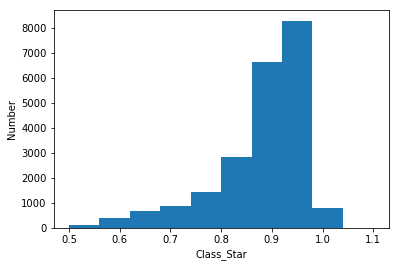

In [4]:
# Just to confirm - since these 
# are quasars, their class_star should be pretty high...
plt.hist(qso['NSCclass_star'], range=(0.5,1.1))
plt.xlabel('Class_Star')
plt.ylabel('Number')

Now, we plot the HLC-NSC all points on u-g,  g-r  diagram,  and overplot the QSO and SDSS using HLC colors. 

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/astropy/table/column.py:929: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, oper)(other)


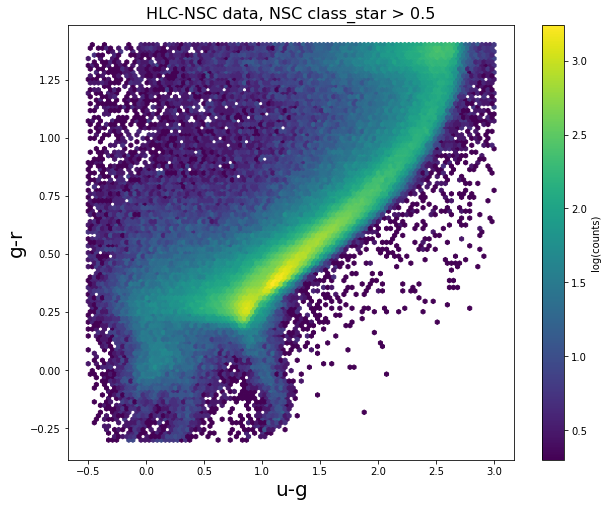

In [15]:
# Select HLC-NSC data : 
# -->  point sources 
m_star = hlc_nsc['NSCclass_star'] > 0.5
# --> signal / noise > 5 
m_sn = hlc_nsc['HLCgmag'] /hlc_nsc['HLCgerr'] > 5
m = m_sn * m_star

ug_hlc,gr_hlc = hlc_nsc['HLCu-g'][m],hlc_nsc['HLCg-r'][m]

# 2D-histogram of objects in the g-r vs r-i color diagram 
fig, ax1 = plt.subplots(1, 1, figsize=(10, 8))
im1 = ax1.hexbin(hlc_nsc['HLCu-g'][m],
                 hlc_nsc['HLCg-r'][m] ,bins='log', cmap=plt.cm.viridis,
               mincnt=1, extent=(-0.5,3, -0.3,1.4))
ax1.set_title('HLC-NSC data, NSC class_star > 0.5', fontsize=16)
ax1.set_xlabel('u-g',fontsize=20)
ax1.set_ylabel('g-r',fontsize=20)
plt.colorbar(im1, label='log(counts)')
plt.savefig('hlc_nsc_point_sources.png', bbox_inches='tight')

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/astropy/table/column.py:929: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, oper)(other)
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


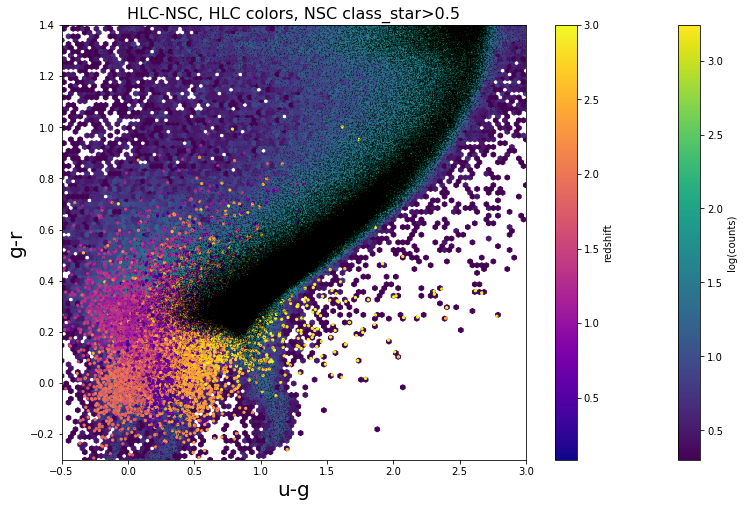

In [14]:
# 2D-histogram of objects in the g-r vs r-i color diagram 
fig, ax1 = plt.subplots(1, 1, figsize=(13, 8))
im1 = ax1.hexbin(ug_hlc,gr_hlc, bins='log', cmap=plt.cm.viridis,
               mincnt=1, extent=(-0.5,3, -0.3,1.4))
plt.colorbar(im1, label='log(counts)')

# QSO
# -->  point sources 
m_star = qso['NSCclass_star'] > 0.5
# --> signal / noise > 5 
m_sn = qso['HLCgmag'] / qso['HLCgerr'] > 5
m = m_sn * m_star

ug_qso = qso['HLCu-g'][m]
gr_qso = qso['HLCg-r'][m]
redshift_qso=qso['Z'].data[m]
cmap = plt.get_cmap('plasma', len(redshift_qso)) 


# STARS
# -->  point sources 
m_star = stars['NSCclass_star'] > 0.5
# --> signal / noise > 5 
m_sn = stars['HLCgmag'] / stars['HLCgerr'] > 5
m = m_sn * m_star

ug_star = stars['HLCu-g'][m]
gr_star = stars['HLCg-r'][m]

# QUASARS
im = ax1.scatter(ug_qso, gr_qso, c=redshift_qso, cmap=cmap, s=5, vmax=3)
plt.colorbar(im, label='redshift')

# STARS 
ax1.scatter(ug_star, gr_star,c='k',s=0.01, label='stars')

ax1.set_xlim(-0.5,3)
ax1.set_ylim(-0.3,1.4)
ax1.set_xlabel('u-g',fontsize=20)
ax1.set_ylabel('g-r',fontsize=20)
ax1.set_title('HLC-NSC, HLC colors, NSC class_star>0.5', fontsize=16)
plt.savefig('hlc_nsc_qso_stars.png', bbox_inches='tight')

In this plot above, quasars (QSOs) are colored by their redshift (i.e. orange and yellow dots on bottom left), and the black points are SDSS standard stars.  The background are all HLC-NSC sources. Since the plot makes a clear distinction between the quasars and stars, it tells us that indeed it is possible to separate stars and QSO using u-g vs. g-r color information. 

##  3) Classification of data <a id='step3'></a>

[Go to top](#toc)

In the following analysis, we use only SDSS DR14 QSO and SDSS Standard stars with HLC colors. We setup the training set (X), with correct labels (y) . We use a split_samples() function to split samples into training, test, and cross-validation sets, treating 90% as training and 10% as test sets (as was done in the book example): X_test, X_train,  and y_test,  y_train. In the process, we predict the labels y_pred for the X_test sample. The ROC curves use the predicted labels y_pred against the true labels in the test set y_test. It tells us how well we are doing with the fully labeled data.  

The  HLC-NSC  1 GB catalog with unknown labels y could  be used to classify the unknown objects using either of the classifier, quoting the completeness / contamination / FPR, etc. , based on the test set above, under the assumption that the qso/sdss  and hlc-nsc full dataset are morphologically similar. This is however beyond the scope of this homework, and could be a paper on its own. 

Firstm,  make a test set and a training set for all classifications : 

In [16]:
def fetch_dr14_quasars(qso):
    # SDSS DR14 QSO cross-matched to HLC-NSC catalog 
    # --> signal / noise > 5 
    m_g_sn = qso['HLCgmag'] / qso['HLCgerr'] > 5
    m_u_sn = qso['HLCumag'] / qso['HLCuerr'] > 5
    m_r_sn = qso['HLCrmag'] / qso['HLCrerr'] > 5
    m_redshift = qso['Z'] < 2.5

    m = m_g_sn * m_u_sn * m_r_sn  * m_redshift
    print('We select ', np.sum(m), ' of ', len(m))
    quasars = qso[m]
    return quasars

def fetch_standard_stars(stars):
    # STARS
    # --> signal / noise > 5 
    m_g_sn = stars['HLCgmag'] / stars['HLCgerr'] > 5
    m_u_sn = stars['HLCumag'] / stars['HLCuerr'] > 5
    m_r_sn = stars['HLCrmag'] / stars['HLCrerr'] > 5

    m =  m_g_sn * m_u_sn* m_r_sn
    print('We select ', np.sum(m), ' of ', len(m))
    stars = stars[m]
    return stars

quasars =  fetch_dr14_quasars(qso)
stars = fetch_standard_stars(stars)

# stack colors into matrix X : it is the training set 
# size : ( number of qso + number of stars ) * ( number of colors )
Nqso = len(quasars)
Nstars = len(stars)
X = np.empty((Nqso + Nstars, 4), dtype=float)

X[:Nqso, 0] = quasars['HLCu-g']
X[:Nqso, 1] = quasars['HLCg-r']
X[:Nqso, 2] = quasars['HLCr-i']
X[:Nqso, 3] = quasars['HLCi-z']

X[Nqso:, 0] = stars['HLCu-g']
X[Nqso:, 1] = stars['HLCg-r']
X[Nqso:, 2] = stars['HLCr-i']
X[Nqso:, 3] = stars['HLCi-z']

# Make a vector with labels 
y = np.zeros(Nqso + Nstars, dtype=int)
y[:Nqso] = 1  # 1 = qso ,  0 = star 

# split into training and test sets
(X_train, X_test), (y_train, y_test) = split_samples(X, y, [0.9, 0.1],
                                                     random_state=0)



/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/astropy/table/column.py:929: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, oper)(other)
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


We select  7250  of  22205
We select  260872  of  693857


## 3.1) Comparison of different methods (Naive Bayes, KNN, Decision Trees) <a id='compare'></a>

[Go to top](#toc)

We first test all methods with a  suitable parameters  chosen a priori.  Eg. for all classifiers we use only 2 colors : u-g vs g-r, which are the most informative for qso-star separation . For KNN we set N=10,  for Decision Tree we set depth to 12, in GMM Bayes we use 3 components. 

After this comparison, we present more in-depth investigation of KNN, Naive Bayes, and Decision Trees. In particular, we consider how does completeness / contamination change as a function of number of colors used for classification, and the dependence of ROC on parameters particular to each model (eg. N in KNN, or depth for Decision Trees). 

GaussianNB
LinearDiscriminantAnalysis
QuadraticDiscriminantAnalysis
LogisticRegression
KNeighborsClassifier
DecisionTreeClassifier
GMMBayes


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/chris/anaconda3/envs/py36/lib/python3.

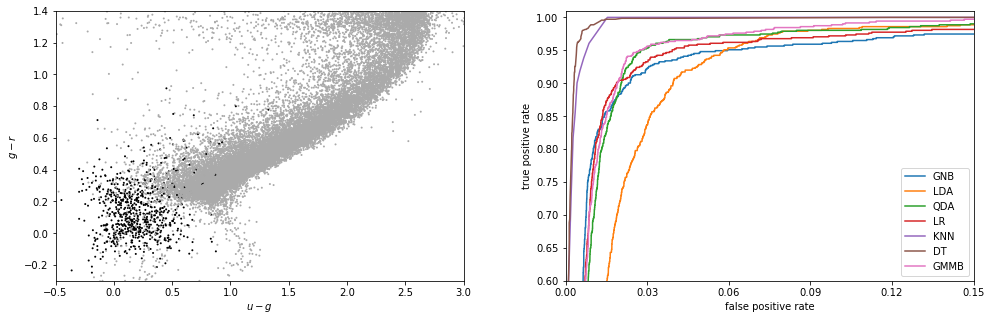

In [17]:
#------------------------------------------------------------
# Compute fits for all the classifiers
def compute_results(*args):
    names = []
    probs = []

    for classifier, kwargs in args:
        print(classifier.__name__)
        model = classifier(**kwargs)
        model.fit(X, y)
        y_prob = model.predict_proba(X_test)

        names.append(classifier.__name__)
        probs.append(y_prob[:, 1])

    return names, probs

LRclass_weight = dict([(i, np.sum(y_train == i)) for i in (0, 1)])

names, probs = compute_results((GaussianNB, {}),
                               (LDA, {}),
                               (QDA, {}),
                               (LogisticRegression,
                                dict(class_weight=LRclass_weight)),
                               (KNeighborsClassifier,
                                dict(n_neighbors=10)),
                               (DecisionTreeClassifier,
                                dict(random_state=0, max_depth=12,
                                     criterion='entropy')),
                               (GMMBayes, dict(n_components=3, min_covar=1E-5,
                                               covariance_type='full')))

#------------------------------------------------------------
# Plot results
fig = plt.figure(figsize=(15, 5))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15, top=0.9, wspace=0.25)

# First axis shows the data
ax1 = fig.add_subplot(121)
im = ax1.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=4,
                 linewidths=0, edgecolors='none',
                 cmap=plt.cm.binary)
im.set_clim(-0.5, 1)
ax1.set_xlim(-0.5, 3.0)
ax1.set_ylim(-0.3, 1.4)
ax1.set_xlabel('$u - g$')
ax1.set_ylabel('$g - r$')

labels = dict(GaussianNB='GNB',
              LinearDiscriminantAnalysis='LDA',
              QuadraticDiscriminantAnalysis='QDA',
              KNeighborsClassifier='KNN',
              DecisionTreeClassifier='DT',
              GMMBayes='GMMB',
              LogisticRegression='LR')

# Second axis shows the ROC curves
ax2 = fig.add_subplot(122)
for name, y_prob in zip(names, probs):
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)

    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])

    ax2.plot(fpr, tpr, label=labels[name])

ax2.legend(loc=4)
ax2.set_xlabel('false positive rate')
ax2.set_ylabel('true positive rate')
ax2.set_xlim(0, 0.15)
ax2.set_ylim(0.6, 1.01)
ax2.xaxis.set_major_locator(plt.MaxNLocator(5))
plt.savefig('compare_classifiers.png', bbox_inches='tight')
plt.show()

On the figure above the left panel shows the  training/test data on a color-color diagram, with stars in grey, and quasars in black. The right panel shows the ROC curves for different methods (Gaussian Naive Bayes,  Linear Discriminant Analysis,  Quadratic Discriminant Analysis, Linear Regression, K Nearest Neighbors, Decision Trees, Gaussian Mixture Model Bayes) for quasar classification based on HLC dereddened u-g, g-r, r-i, and i-z colors. By far the best method for this dataset is Decision Trees, followed by KNN.

##  3.2) KNN classification <a id='knn'></a>

[Go to top](#toc)

The color order in the following plots is u-g,  g-r,  r-i, i-z. Since quasars are well separated from stars even using only u-g color (vertical line), this is a good order. For the RR Lyrae example in the book (Fig. 9.7) the color order is changed from [0,1,2,3] to [1,0,2,3] since RR Lyrae are better separated from stars horizontally (horizontal line). Our program is inspired by code from Fig. 9.7 in the textbook.

completeness [[ 0.46910112  0.66994382  0.73595506  0.76404494]
 [ 0.58146067  0.76825843  0.84550562  0.84269663]
 [ 0.51966292  0.74578652  0.83707865  0.83707865]
 [ 0.62359551  0.78792135  0.84269663  0.85955056]]
contamination [[ 0.52489331  0.34024896  0.25462304  0.22285714]
 [ 0.40602582  0.22957746  0.18428184  0.16550765]
 [ 0.3843594   0.21099554  0.16174402  0.13997114]
 [ 0.35745297  0.21538462  0.16666667  0.14763231]]


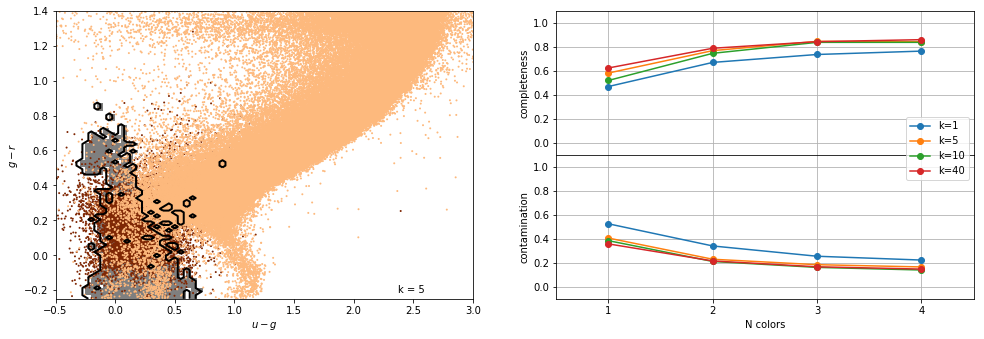

In [18]:
N_tot = len(y)
N_st = np.sum(y == 0)
N_qso = N_tot - N_st
N_train = len(y_train)
N_test = len(y_test)
N_plot = N_tot

#----------------------------------------------------------------------
# perform Classification

classifiers = []
predictions = []
Ncolors = np.arange(1, X.shape[1] + 1)
kvals = [1, 5, 10, 40]

for k in kvals:
    classifiers.append([])
    predictions.append([])
    for nc in Ncolors:
        clf = KNeighborsClassifier(n_neighbors=k)
        clf.fit(X_train[:, :nc], y_train)
        y_pred = clf.predict(X_test[:, :nc])

        classifiers[-1].append(clf)
        predictions[-1].append(y_pred)

completeness, contamination = completeness_contamination(predictions, y_test)

print("completeness", completeness)
print("contamination", contamination)

#------------------------------------------------------------
# Compute the decision boundary
# choose k index  , 
# which selects a k value from 
# kvals[kindex]
kindex = 1
clf = classifiers[kindex][1]
xlim = (-0.5,3)
ylim = (-0.25,1.4)

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 71),
                     np.linspace(ylim[0], ylim[1], 81))

Z = clf.predict(np.c_[yy.ravel(), xx.ravel()])
Z = Z.reshape(xx.shape)

#----------------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(15, 5))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0,
                    left=0.1, right=0.95, wspace=0.2)

# left plot: data and decision boundary
ax = fig.add_subplot(121)
im = ax.scatter(X[-N_plot:, 0], X[-N_plot:, 1], c=y[-N_plot:],
                s=4, lw=0, cmap=plt.cm.Oranges, zorder=2)
im.set_clim(-0.5, 1)

im = ax.imshow(Z, origin='lower', aspect='auto',
               cmap=plt.cm.binary, zorder=1,
               extent=xlim + ylim)
im.set_clim(0, 2)


ax.contour(xx, yy, Z, [0.5],linewidths=2., colors='k')

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel('$u-g$')
ax.set_ylabel('$g-r$')

ax.text(0.82, 0.02, "k = %i" % kvals[kindex],
        transform=ax.transAxes)

# plot completeness vs Ncolors
ax = fig.add_subplot(222)
for i in range(len(kvals)):
    ax.plot(Ncolors, completeness[i], 'o-',ms=6, label='k=%i' % kvals[i])


ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.NullFormatter())

ax.set_ylabel('completeness')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

# plot contamination vs Ncolors
ax = fig.add_subplot(224)
for i in range(len(kvals)):
    ax.plot(Ncolors, contamination[i], 'o-',  ms=6, label='k=%i' % kvals[i])
ax.legend(loc='lower right', bbox_to_anchor=(1.0, 0.79))

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))
ax.set_xlabel('N colors')
ax.set_ylabel('contamination')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)
plt.savefig('knn_comp2.png', bbox_inches='tight')
plt.show()

### Plotting the ROC curve for KNN for different k values up to 2 colors:

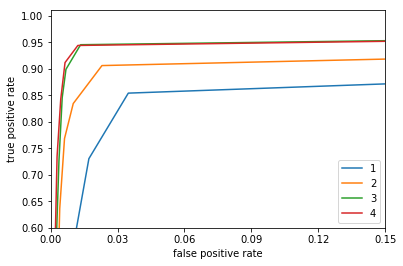

In [19]:
fig,ax = plt.subplots(1,1)
ax2 = ax
k = 5 
for nc  in Ncolors: 
    model = KNeighborsClassifier(n_neighbors=k)     
    model.fit(X_train[:, :nc], y_train)
    y_prob = model.predict_proba(X_test[:, :nc])
    y_prob = y_prob[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])
    ax2.plot(fpr, tpr, label=str(nc))

ax2.legend(loc=4)
ax2.set_xlabel('false positive rate')
ax2.set_ylabel('true positive rate')
ax2.set_xlim(0, 0.15)
ax2.set_ylim(0.6, 1.01)
ax2.xaxis.set_major_locator(plt.MaxNLocator(5))
plt.savefig('knn_ROC.png', bbox_inches='tight')
plt.show()

## 3.3) Gaussian Naive Bayes Classification <a id='NaiveBayes'></a>

[Go to top](#toc)



completeness [ 0.          0.7261236   0.73735955  0.12359551]
contamination [ 0.          0.25396825  0.28082192  0.41721854]


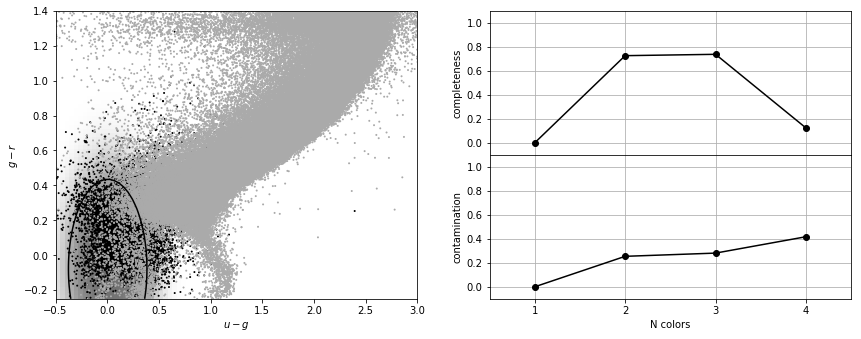

In [12]:
#----------------------------------------------------------------------
# perform Naive Bayes
classifiers = []
predictions = []
Ncolors = np.arange(1, X.shape[1] + 1)

for nc in Ncolors:
    clf = GaussianNB()
    clf.fit(X_train[:, :nc], y_train)
    y_pred = clf.predict(X_test[:, :nc])

    classifiers.append(clf)
    predictions.append(y_pred)

completeness, contamination = completeness_contamination(predictions, y_test)

print("completeness", completeness)
print("contamination", contamination)

#------------------------------------------------------------
# Compute the decision boundary
clf = classifiers[1]
xlim = (-0.5, 3.)
ylim = (-0.25,1.4)

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 81),
                     np.linspace(ylim[0], ylim[1], 71))

Z = clf.predict_proba(np.c_[yy.ravel(), xx.ravel()])
Z = Z[:, 1].reshape(xx.shape)

#----------------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(13, 5))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0,
                    left=0.1, right=0.95, wspace=0.2)

# left plot: data and decision boundary
ax =fig.add_subplot(121)
im = ax.scatter(X[-N_plot:, 0], X[-N_plot:, 1], c=y[-N_plot:],
                s=4, lw=0, cmap=plt.cm.binary, zorder=2)
im.set_clim(-0.5, 1)

im = ax.imshow(Z, origin='lower', aspect='auto',
               cmap=plt.cm.binary, zorder=1,
               extent=xlim + ylim)
im.set_clim(0, 1.5)
ax.contour(xx, yy, Z, [0.5], colors='k')

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel('$u-g$')
ax.set_ylabel('$g-r$')

# Plot completeness vs Ncolors
ax = plt.subplot(222)
ax.plot(Ncolors, completeness, 'o-k', ms=6)

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.NullFormatter())

ax.set_ylabel('completeness')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

# Plot contamination vs Ncolors
ax = plt.subplot(224)
ax.plot(Ncolors, contamination, 'o-k', ms=6)

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))

ax.set_xlabel('N colors')
ax.set_ylabel('contamination')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)
plt.savefig('NaiveBayes_comp2.png', bbox_inches='tight')
plt.show()


### Plotting the ROC curve for Naive Bayes

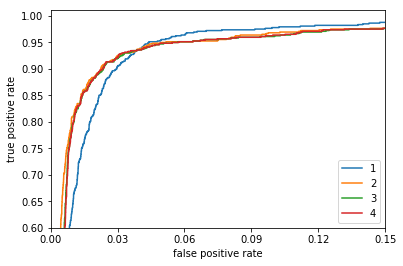

In [13]:
fig,ax = plt.subplots(1,1)
ax2 = ax
for nc  in Ncolors: 
    model = GaussianNB()
    model.fit(X_train[:, :nc], y_train)
    y_prob = model.predict_proba(X_test[:, :nc])
    y_prob = y_prob[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])
    ax2.plot(fpr, tpr, label=str(nc))

ax2.legend(loc=4)
ax2.set_xlabel('false positive rate')
ax2.set_ylabel('true positive rate')
ax2.set_xlim(0, 0.15)
ax2.set_ylim(0.6, 1.01)
ax2.xaxis.set_major_locator(plt.MaxNLocator(5))
plt.savefig('NaiveBayes_ROC.png', bbox_inches='tight')
plt.show()

## 3.4 Decision Tree Classification <a id='DecisionTree'></a>

[Go to top](#toc)



completeness [[ 0.64466292  0.8497191   0.88202247  0.88202247]
 [ 0.59269663  0.76825843  0.86376404  0.85674157]
 [ 0.5997191   0.76685393  0.84410112  0.86516854]
 [ 0.63342697  0.76966292  0.82724719  0.83146067]]
contamination [[ 0.36161335  0.30138568  0.27733026  0.27566321]
 [ 0.3437014   0.22630835  0.23412204  0.23462986]
 [ 0.35885886  0.23529412  0.19328859  0.19477124]
 [ 0.37793103  0.26737968  0.20189702  0.19455782]]


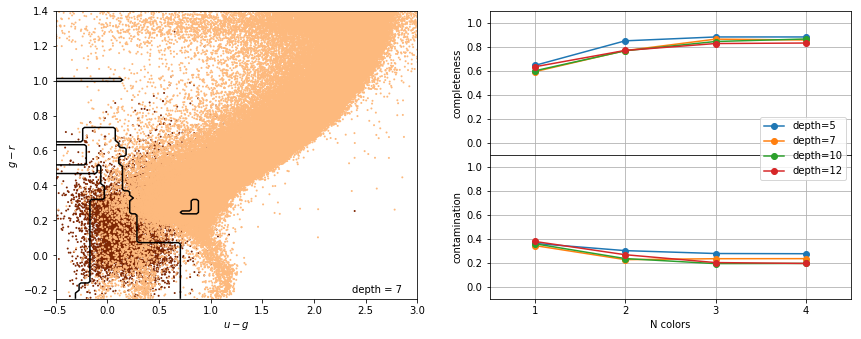

In [14]:
#----------------------------------------------------------------------
# Fit Decision tree
Ncolors = np.arange(1, X.shape[1] + 1)

classifiers = []
predictions = []
Ncolors = np.arange(1, X.shape[1] + 1)
depths = [5,7, 10,12]

for depth in depths:
    classifiers.append([])
    predictions.append([])
    for nc in Ncolors:
        clf = DecisionTreeClassifier(random_state=0, max_depth=depth,
                                     criterion='entropy')
        clf.fit(X_train[:, :nc], y_train)
        y_pred = clf.predict(X_test[:, :nc])

        classifiers[-1].append(clf)
        predictions[-1].append(y_pred)

completeness, contamination = completeness_contamination(predictions, y_test)

print("completeness", completeness)
print("contamination", contamination)

#------------------------------------------------------------
# compute the decision boundary

clf = classifiers[1][1]
xlim = (-0.5, 3.)
ylim = (-0.25,1.4)
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 101),
                     np.linspace(ylim[0], ylim[1], 101))

Z = clf.predict(np.c_[yy.ravel(), xx.ravel()])
Z = Z.reshape(xx.shape)

#----------------------------------------------------------------------
# plot the results(figsize=(13, 5))
fig = plt.figure(figsize=(13,5))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0,
                    left=0.1, right=0.95, wspace=0.2)

# left plot: data and decision boundary
ax = fig.add_subplot(121)
im = ax.scatter(X[-N_plot:, 0], X[-N_plot:, 1], c=y[-N_plot:],
                s=4, lw=0, cmap=plt.cm.Oranges, zorder=2)
im.set_clim(-0.5, 1)

ax.contour(xx, yy, Z, [0.5], colors='k')

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel('$u-g$')
ax.set_ylabel('$g-r$')

ax.text(0.82, 0.02, "depth = %i" % depths[1],
        transform=ax.transAxes)

# plot completeness vs Ncolors
ax = fig.add_subplot(222)
for i in range(len(kvals)):
    ax.plot(Ncolors, completeness[i], 'o-',ms=6, label='depth=%i' % depths[i])

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.NullFormatter())

ax.set_ylabel('completeness')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

# plot contamination vs Ncolors
ax = fig.add_subplot(224)
for i in range(len(kvals)):
    ax.plot(Ncolors, contamination[i], 'o-',ms=6, label='depth=%i' % depths[i])
    
ax.legend(loc='lower right',
          bbox_to_anchor=(1.0, 0.79))

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))

ax.set_xlabel('N colors')
ax.set_ylabel('contamination')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)
plt.savefig('DecisionTree_comp2.png', bbox_inches='tight')
plt.show()

### Plotting ROC for Decision Trees as a function of colors  (setting depth to be fixed at 5):

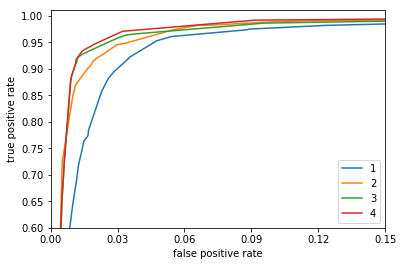

In [15]:
fig,ax = plt.subplots(1,1)
ax2 = ax

depth = 5 
for nc  in Ncolors: 
    model = DecisionTreeClassifier(random_state=0, max_depth=depth,
                                     criterion='entropy')
    model.fit(X_train[:, :nc], y_train)
    y_prob = model.predict_proba(X_test[:, :nc])
    y_prob = y_prob[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])
    ax2.plot(fpr, tpr, label=str(nc))

ax2.legend(loc=4)
ax2.set_xlabel('false positive rate')
ax2.set_ylabel('true positive rate')
ax2.set_xlim(0, 0.15)
ax2.set_ylim(0.6, 1.01)
ax2.xaxis.set_major_locator(plt.MaxNLocator(5))
plt.savefig('DecisionTree_ROC.png', bbox_inches='tight')
plt.show()

# Addendum <a id='addendum'></a>

[Go to top](#toc)

Here we explain why u-g vs g-r  is a good color choice for separating quasars from stars, and why it is a good idea to limit the redshift range in the training sample to limit the contamination of high-redshift quasars that overlap the stellar locus. 

First, from [Bovy et al. 2011](http://iopscience.iop.org/article/10.1088/0004-637X/729/2/141/pdf), we see a good illustration of how QSO really move out of the $u-g<0.5$ locus beyond z=2:  <img src='figs/bovy2011_fig7.png' width=900>

It is supported by [Fan et al.1999](http://iopscience.iop.org/article/10.1086/300848/pdf), who shows here the redshift color evolution of quasars: 
<img src='figs/fan1999_fig12.png'>

Finally, Suberlak+2017 used the LSST-reprocessed S82 data, to plot the color-color diagram like Fig.1 in  [Ivezic+2004](http://faculty.washington.edu/ivezic/Publications/astroph_0310566.pdf).
<img src='figs/suberlak2017_fig11.png' width=500> Here colors in the upper-right panel indicate the class to which objects belong given their location in the color-color space. Objects in the red region are mostly quasars,  those in the blue are hot stars (white dwarfs),  in black - main sequence stars, and in green - the transitional region. It shows that indeed quasars occupy the same color-color space as in Fig.9.18 from AstroML <img src='figs/fig9-18_astroml.png' width=600>  
Here "stars are indicated by gray points, while quasars are indicated by black points." (http://www.astroml.org/book_figures/chapter9/fig_star_quasar_ROC.html)